In [4]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
os.chdir(os.path.dirname(os.getcwd()))

In [5]:
# import results
results = pd.read_csv('results/parallel/results.csv')

# get cross-validated mse across folds for each dataset
cv_mse = results.groupby('dataset').mean().reset_index()

# drop fold variable
cv_mse.drop(['fold'], axis=1, inplace=True)

In [6]:
# calculate ratio of mse to lm mse
cv_mse_lm_ratio = cv_mse.copy()
for col in cv_mse_lm_ratio.columns[2:cv_mse_lm_ratio.shape[1]]:
    cv_mse_lm_ratio[col] = cv_mse_lm_ratio[col]/cv_mse_lm_ratio['linear_mod']
cv_mse_lm_ratio['linear_mod'] = 1.0

# drop extreme ouutlier
outlier_index = cv_mse_lm_ratio.index[cv_mse_lm_ratio['sl_full'] == cv_mse_lm_ratio['sl_full'].max()].tolist()
cv_mse_lm_ratio.drop(index=outlier_index, axis=0, inplace=True)

In [7]:
# calculate geometric means for each tuning strategy
geo_means = []
names = []
for col in cv_mse_lm_ratio.columns[2:cv_mse_lm_ratio.shape[1]]:
    names.append(col)
    geo_means.append(sp.gmean(cv_mse_lm_ratio[col]))

geo_means = pd.DataFrame({'name': names, 
                          'geo_mean': geo_means})
geo_means.sort_values(['geo_mean'], inplace=True)
geo_means = geo_means.reset_index(drop=True)
geo_means['name_clean'] = ['Grid Search (1)', 'Random Seach (100:1)', 'Discrete',
                           'Genetic Algorithm', 'Random Search (50:1)', 'Random Search (25:1)',
                           'Random Seach (10:1)', 'Random Search (100:5)', 'Random Search (100:3)',
                           'Grid Search (5)', 'Random Search (50:5)', 'Grid Search (3)', 
                           'Random Search (50:3)', 'Random Search (25:5)', 'Random Search (25:3)',
                           'Comprehensive', 'Random Search (10:3)', 'Random Search (10:5)',
                           'Default']

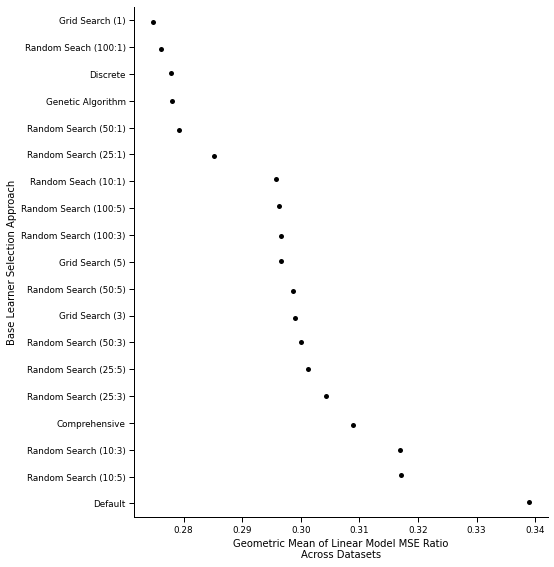

In [8]:
# plot geometric means
sns.set_context("paper", rc={"font.size":16,
                             "axes.titlesize":16,
                             "axes.labelsize":10})
ax = sns.catplot(x='geo_mean', 
                 y='name_clean',
                 data=geo_means,
                 order=geo_means.sort_values(['geo_mean'])['name_clean'].tolist(),
                 color='black',
                 height=8)
ax.set(xlabel="Geometric Mean of Linear Model MSE Ratio\nAcross Datasets", ylabel = "Base Learner Selection Approach")
#ax.set_title("Geometric Mean MSE for Base Learner Selection Approaches")
#ax.set_xlabel("Geometric Mean of MSE\nAcross Datasets")
#ax.set_ylabel("Base Learner Selection Approach")
#sns.plt.show()



In [14]:
cv_mse_lm_ratio_long = pd.melt(cv_mse_lm_ratio, 
                       id_vars=['dataset'], 
                       value_vars=cv_mse_lm_ratio.columns[2:cv_mse_lm_ratio.shape[1]].tolist())
cv_mse_lm_ratio_long['hue'] = 'Estimate for single dataset'

In [15]:
cv_mse_lm_ratio_long = pd.merge(cv_mse_lm_ratio_long,
                                geo_means[['name', 'name_clean']], 
                                left_on ='variable',
                                right_on='name')
cv_mse_lm_ratio_long.drop(['name'], axis=1, inplace=True)

In [16]:
cv_mse_lm_ratio_long

,dataset,variable,value,hue,name_clean
0,1027_ESL,sl_full,0.998985,Estimate for single dataset,Comprehensive
1,1028_SWD,sl_full,0.999074,Estimate for single dataset,Comprehensive
2,1029_LEV,sl_full,1.036254,Estimate for single dataset,Comprehensive
3,1030_ERA,sl_full,1.002020,Estimate for single dataset,Comprehensive
4,1089_USCrime,sl_full,0.972998,Estimate for single dataset,Comprehensive
...,...,...,...,...,...
1838,687_sleuth_ex1605,discrete_sl,1.176358,Estimate for single dataset,Discrete
1839,690_visualizing_galaxy,discrete_sl,0.755119,Estimate for single dataset,Discrete
1840,695_chatfield_4,discrete_sl,1.010586,Estimate for single dataset,Discrete
1841,706_sleuth_case1202,discrete_sl,1.385713,Estimate for single dataset,Discrete


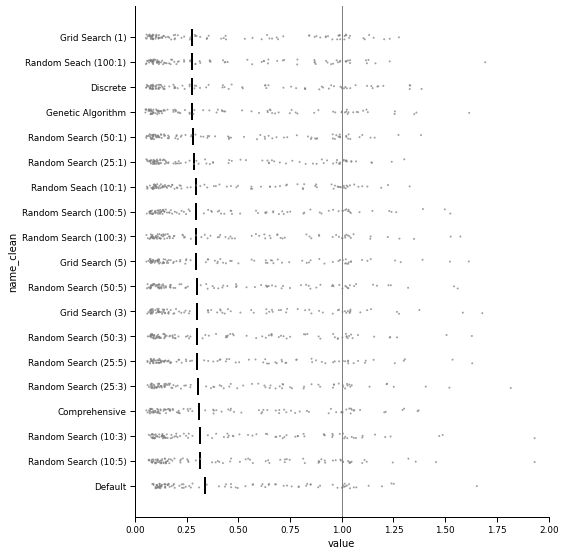

In [17]:
# plot individual dataset mse values and geometric means
ax = sns.catplot(x='value', 
                 y='name_clean',
                 data=cv_mse_lm_ratio_long,
                 order=geo_means.sort_values(['geo_mean'])['name_clean'].tolist(),
                 s=2,
                 color='grey',
                 alpha=0.75,
                 legend=True,
                 height=8)
ax.axes[0, 0].axvline(x = 1, color='grey', linewidth=1)
ax.set(xlim=(0, 2))
for index, row in geo_means.iterrows():
    ax.axes[0, 0].plot((row['geo_mean'], row['geo_mean']), 
                      (int(index) - 0.3 , int(index) + 0.3), 
                      'k', linewidth=2) 



In [18]:
strategies = geo_means['name_clean'].values
datasets = cv_mse_lm_ratio_long.dataset.unique()

dim = len(cv_mse_lm_ratio_long.variable.unique())
perf_matrix = np.zeros((dim, dim))
results = cv_mse_lm_ratio_long.copy()
for i in np.array(strategies):
    i_num = np.where(strategies==i)[0][0]
    for j in np.array(strategies):
        j_num = np.where(strategies==j)[0][0]
        for d in datasets:
            i_val = results.loc[(results['dataset']==d) & (results['name_clean']==i), 'value'].values[0]
            j_val = results.loc[(results['dataset']==d) & (results['name_clean']==j), 'value'].values[0]
            if i_val < j_val:
                perf_matrix[i_num, j_num] = perf_matrix[i_num, j_num] + 1
                
perf_matrix = perf_matrix / len(datasets)

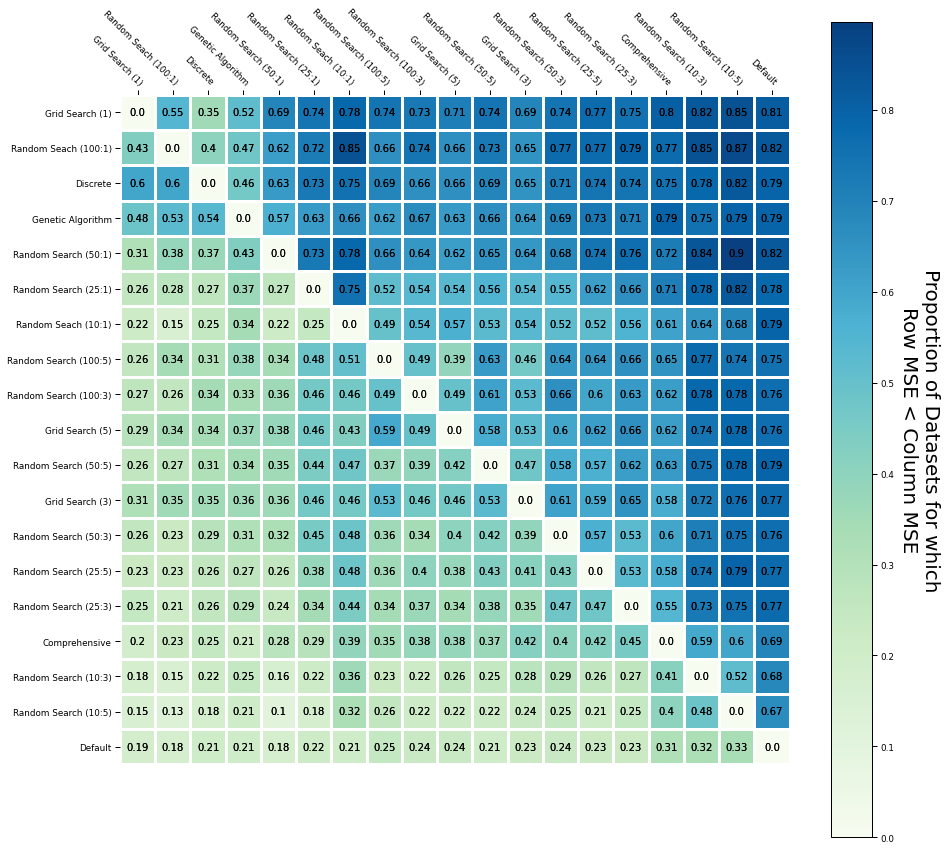

In [29]:
sns.set_context("paper", rc={"font.size":10,
                             "axes.titlesize":16,
                             "axes.labelsize":10})

fig, ax = plt.subplots(figsize=(15,15))

# Plot the heatmap
im = ax.imshow(perf_matrix, cmap='GnBu')

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Proportion of Datasets for which\nRow MSE < Column MSE', 
                   rotation=-90, va="bottom", size = 20)

# We want to show all ticks...
ax.set_xticks(np.arange(perf_matrix.shape[1]))
ax.set_yticks(np.arange(perf_matrix.shape[0]))
# ... and label them with the respective list entries.
strategies_clean = geo_means['name_clean']
ax.set_xticklabels(strategies_clean)
ax.set_yticklabels(strategies_clean)

# Let the horizontal axes labeling appear on top.
ax.tick_params(top=True, bottom=False,
               labeltop=True, labelbottom=False)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=-45, ha="right",
         rotation_mode="anchor")

# Turn spines off and create white grid.
for edge, spine in ax.spines.items():
    spine.set_visible(False)

ax.set_xticks(np.arange(perf_matrix.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(perf_matrix.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)

for (j,i),label in np.ndenumerate(perf_matrix):
    ax.text(i, j, np.round(label, 2), ha='center', va='center')
    ax.text(i, j, np.round(label, 2), ha='center', va='center')

plt.show()

In [55]:
learners = pd.read_csv('results/parallel/base_learner_details.csv')


In [57]:
learner_mse = pd.read_csv('results/parallel/base_learner_cv_mse.csv')

In [52]:
learner_mse.drop(['dataset', 'seed'], axis=1, inplace=True)

In [53]:
learner_mse = learner_mse.transpose()

In [54]:
learner_mse

,0,1,2,3,4,5,6,7,8,9,...,970,971,972,973,974,975,976,977,978,979
0,0.145497,0.141160,0.136956,0.141826,0.139001,0.138129,0.143092,0.143160,0.138153,0.139766,...,0.213193,0.225658,0.228014,0.225695,0.239396,0.226473,0.241993,0.240561,0.233047,0.233891
1,0.160861,0.156400,0.152304,0.156579,0.155290,0.153990,0.157937,0.158395,0.153945,0.154796,...,0.224018,0.241913,0.239717,0.239024,0.254883,0.239418,0.256778,0.253755,0.247692,0.251285
2,0.537427,0.515902,0.526955,0.513885,0.540568,0.529609,0.518622,0.518546,0.536094,0.523014,...,0.465425,0.487307,0.480899,0.483783,0.496355,0.480173,0.504766,0.507157,0.499701,0.505733
3,1.001281,1.035040,0.965775,1.019949,0.950481,0.985291,1.030071,1.037695,1.015861,1.009815,...,0.983745,0.985980,1.062415,0.984259,1.025872,1.044154,1.026183,1.002041,1.008912,0.984122
4,1.001281,1.035040,0.965775,1.019949,0.950481,0.985291,1.030071,1.037695,1.015861,1.009815,...,0.983745,0.985980,1.062415,0.984259,1.025872,1.044154,1.026183,1.002041,1.008912,0.984122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,0.174819,0.164590,0.155835,0.175612,0.161279,0.170398,0.184692,0.171894,0.169401,0.184438,...,0.285101,0.318535,0.278226,0.269049,0.301146,0.280540,0.306750,0.310065,0.296372,0.297020
666,0.159348,0.150219,0.142498,0.153849,0.149493,0.155387,0.159479,0.152053,0.155452,0.153554,...,0.221899,0.255555,0.227730,0.239222,0.248016,0.230925,0.254375,0.245753,0.233652,0.236812
667,0.179683,0.165604,0.158505,0.178010,0.163451,0.176027,0.187733,0.175027,0.173427,0.183872,...,0.280716,0.314397,0.273293,0.269547,0.298602,0.276212,0.304093,0.307515,0.294171,0.297344
668,0.160725,0.156392,0.146387,0.160329,0.155504,0.156225,0.160415,0.154586,0.162167,0.157333,...,0.219437,0.246986,0.218304,0.241907,0.249014,0.232088,0.253188,0.239524,0.236707,0.237137


In [61]:
learner_mse = learner_mse.groupby('dataset').mean().reset_index()

In [62]:
learner_mse

,dataset,seed,0,1,2,3,4,5,6,7,...,660,661,662,663,664,665,666,667,668,669
0,1027_ESL,5.5,0.140674,0.156050,0.526062,1.005126,1.005126,1.005126,1.005126,1.005126,...,0.150342,0.171083,0.148251,0.170623,0.148351,0.171296,0.153133,0.174134,0.157006,0.176187
1,1028_SWD,5.5,0.606877,0.657857,0.995868,1.002193,1.002193,1.002193,1.002193,1.002193,...,0.652186,0.658068,0.629792,0.643056,0.631289,0.636021,0.644155,0.636359,0.634500,0.636420
2,1029_LEV,5.5,0.437518,0.483467,0.922400,1.001219,1.001219,1.001219,1.001219,1.001219,...,0.506782,0.507716,0.484382,0.489765,0.469716,0.481207,0.460516,0.479793,0.453608,0.479659
3,1030_ERA,5.5,0.627932,0.672272,1.002368,1.002368,1.002368,1.002368,1.002368,1.002368,...,0.731134,0.731134,0.694601,0.694601,0.665207,0.665557,0.646597,0.648639,0.641443,0.645179
4,1089_USCrime,5.5,0.221630,0.218251,0.526040,1.055274,1.055274,1.055274,1.055274,1.055274,...,0.270724,0.254912,0.282066,0.263219,0.305209,0.282509,0.414150,0.356609,0.522553,0.433196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,687_sleuth_ex1605,5.5,0.470864,0.455181,0.727120,1.046903,1.046903,1.046903,1.046903,1.046903,...,0.596885,0.564501,0.589790,0.557987,0.592630,0.562853,0.638602,0.598654,0.700359,0.647351
94,690_visualizing_galaxy,5.5,0.104530,0.121146,0.452787,1.003425,1.003425,1.003425,1.003425,1.003425,...,0.025404,0.024839,0.026229,0.024509,0.029869,0.025434,0.034082,0.026525,0.037390,0.027446
95,695_chatfield_4,5.5,0.135201,0.141045,0.408492,1.006321,1.007473,1.007473,1.007473,1.007473,...,0.188034,0.185747,0.190082,0.186606,0.201234,0.195369,0.216220,0.207922,0.227112,0.217314
96,706_sleuth_case1202,5.5,0.355623,0.361496,0.642558,1.017952,1.017952,1.017952,1.017952,1.017952,...,0.483437,0.466338,0.525767,0.501626,0.555757,0.526928,0.559960,0.534533,0.576217,0.550755


In [64]:
# calculate ratio of mse to lm mse
learner_mse_lm_ratio = learner_mse.copy()
for col in learner_mse_lm_ratio.columns[2:learner_mse_lm_ratio.shape[1]]:
    learner_mse_lm_ratio[col] = learner_mse_lm_ratio[col]/learner_mse_lm_ratio['0']
cv_mse_lm_ratio['0'] = 1.0

In [65]:
learner_mse_lm_ratio

,dataset,seed,0,1,2,3,4,5,6,7,...,660,661,662,663,664,665,666,667,668,669
0,1027_ESL,5.5,1.0,0.156050,0.526062,1.005126,1.005126,1.005126,1.005126,1.005126,...,0.150342,0.171083,0.148251,0.170623,0.148351,0.171296,0.153133,0.174134,0.157006,0.176187
1,1028_SWD,5.5,1.0,0.657857,0.995868,1.002193,1.002193,1.002193,1.002193,1.002193,...,0.652186,0.658068,0.629792,0.643056,0.631289,0.636021,0.644155,0.636359,0.634500,0.636420
2,1029_LEV,5.5,1.0,0.483467,0.922400,1.001219,1.001219,1.001219,1.001219,1.001219,...,0.506782,0.507716,0.484382,0.489765,0.469716,0.481207,0.460516,0.479793,0.453608,0.479659
3,1030_ERA,5.5,1.0,0.672272,1.002368,1.002368,1.002368,1.002368,1.002368,1.002368,...,0.731134,0.731134,0.694601,0.694601,0.665207,0.665557,0.646597,0.648639,0.641443,0.645179
4,1089_USCrime,5.5,1.0,0.218251,0.526040,1.055274,1.055274,1.055274,1.055274,1.055274,...,0.270724,0.254912,0.282066,0.263219,0.305209,0.282509,0.414150,0.356609,0.522553,0.433196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,687_sleuth_ex1605,5.5,1.0,0.455181,0.727120,1.046903,1.046903,1.046903,1.046903,1.046903,...,0.596885,0.564501,0.589790,0.557987,0.592630,0.562853,0.638602,0.598654,0.700359,0.647351
94,690_visualizing_galaxy,5.5,1.0,0.121146,0.452787,1.003425,1.003425,1.003425,1.003425,1.003425,...,0.025404,0.024839,0.026229,0.024509,0.029869,0.025434,0.034082,0.026525,0.037390,0.027446
95,695_chatfield_4,5.5,1.0,0.141045,0.408492,1.006321,1.007473,1.007473,1.007473,1.007473,...,0.188034,0.185747,0.190082,0.186606,0.201234,0.195369,0.216220,0.207922,0.227112,0.217314
96,706_sleuth_case1202,5.5,1.0,0.361496,0.642558,1.017952,1.017952,1.017952,1.017952,1.017952,...,0.483437,0.466338,0.525767,0.501626,0.555757,0.526928,0.559960,0.534533,0.576217,0.550755


In [66]:
learner_mse.drop(['dataset', 'seed'], axis=1, inplace=True)

In [67]:
learner_mse = learner_mse.transpose()

In [68]:
learner_mse

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,0.140674,0.606877,0.437518,0.627932,0.221630,0.401445,0.464460,0.217886,0.216018,0.151046,...,0.333579,0.028636,0.678147,0.435001,0.653914,0.470864,0.104530,0.135201,0.355623,0.230792
1,0.156050,0.657857,0.483467,0.672272,0.218251,0.167353,0.489944,0.212001,0.215886,0.167932,...,0.322872,0.049822,0.686258,0.480476,0.663950,0.455181,0.121146,0.141045,0.361496,0.244848
2,0.526062,0.995868,0.922400,1.002368,0.526040,0.504422,0.781088,0.483775,0.489235,0.559199,...,0.566337,0.383220,0.940197,0.738952,0.923551,0.727120,0.452787,0.408492,0.642558,0.491130
3,1.005126,1.002193,1.001219,1.002368,1.055274,1.054888,1.045021,1.009232,1.017095,1.021726,...,1.036863,1.019876,1.012728,1.002555,1.024429,1.046903,1.003425,1.006321,1.017952,1.010768
4,1.005126,1.002193,1.001219,1.002368,1.055274,1.061670,1.045021,1.009995,1.017538,1.021732,...,1.038660,1.020112,1.012728,1.002555,1.024429,1.046903,1.003425,1.007473,1.017952,1.010768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,0.171296,0.636021,0.481207,0.665557,0.282509,0.283072,0.488984,0.222531,0.230116,0.357255,...,0.507619,0.021230,0.794996,0.490664,0.724794,0.562853,0.025434,0.195369,0.526928,0.294280
666,0.153133,0.644155,0.460516,0.646597,0.414150,0.427760,0.528311,0.305933,0.312669,0.432846,...,0.518721,0.047597,0.795021,0.517268,0.719607,0.638602,0.034082,0.216220,0.559960,0.239394
667,0.174134,0.636359,0.479793,0.648639,0.356609,0.317628,0.517482,0.251444,0.258070,0.402960,...,0.497967,0.030700,0.764079,0.503307,0.718304,0.598654,0.026525,0.207922,0.534533,0.291589
668,0.157006,0.634500,0.453608,0.641443,0.522553,0.516271,0.574947,0.320426,0.324435,0.473954,...,0.579195,0.072780,0.796447,0.521054,0.719096,0.700359,0.037390,0.227112,0.576217,0.237429


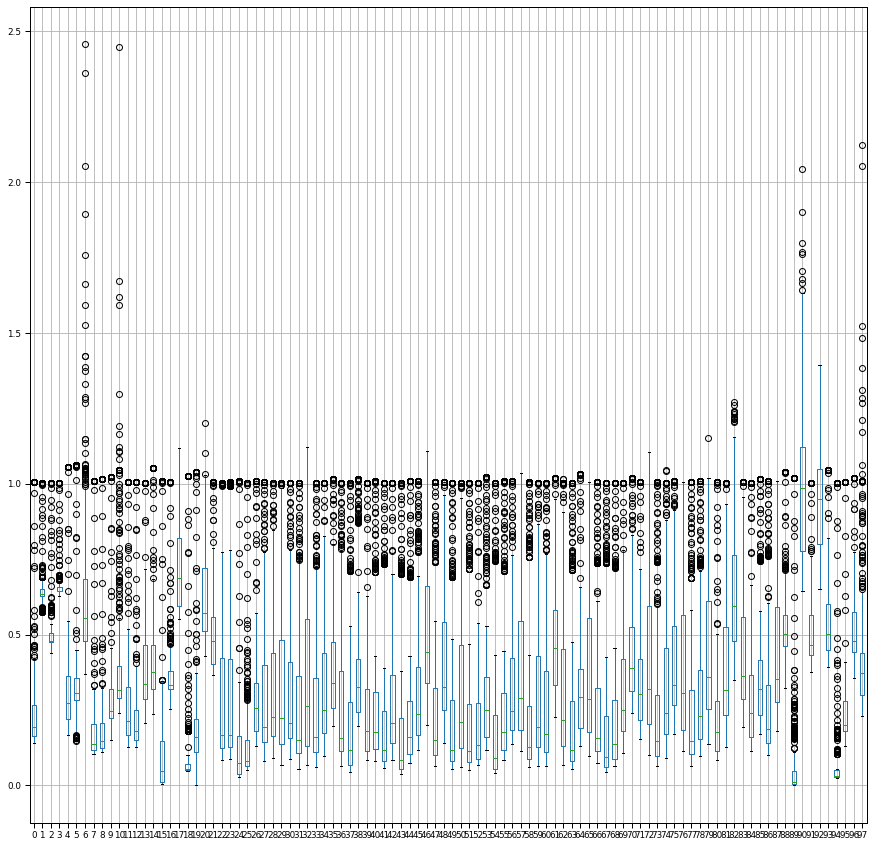

In [70]:
fig, ax = plt.subplots(figsize=(15,15))

import seaborn as sns
import matplotlib.pyplot as plt
learner_mse.boxplot()

In [85]:
learners['mod_num'] = learners.index.values.astype(int)
learner_mse['mod_num'] = learner_mse.index.values.astype(int)
learner_data = pd.merge(learners, learner_mse, on='mod_num')


In [86]:
learner_data

,model_type,copy_X,fit_intercept,n_jobs,normalize,alpha,max_iter,positive,precompute,random_state,...,88,89,90,91,92,93,94,95,96,97
0,LinearRegression,True,True,NaN,False,NaN,NaN,NaN,NaN,NaN,...,0.333579,0.028636,0.678147,0.435001,0.653914,0.470864,0.104530,0.135201,0.355623,0.230792
1,Lasso,True,True,NaN,False,0.1,1000.0,False,False,NaN,...,0.322872,0.049822,0.686258,0.480476,0.663950,0.455181,0.121146,0.141045,0.361496,0.244848
2,Lasso,True,True,NaN,False,0.5,1000.0,False,False,NaN,...,0.566337,0.383220,0.940197,0.738952,0.923551,0.727120,0.452787,0.408492,0.642558,0.491130
3,Lasso,True,True,NaN,False,1.0,1000.0,False,False,NaN,...,1.036863,1.019876,1.012728,1.002555,1.024429,1.046903,1.003425,1.006321,1.017952,1.010768
4,Lasso,True,True,NaN,False,5.0,1000.0,False,False,NaN,...,1.038660,1.020112,1.012728,1.002555,1.024429,1.046903,1.003425,1.007473,1.017952,1.010768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,KNeighborsRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.507619,0.021230,0.794996,0.490664,0.724794,0.562853,0.025434,0.195369,0.526928,0.294280
666,KNeighborsRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.518721,0.047597,0.795021,0.517268,0.719607,0.638602,0.034082,0.216220,0.559960,0.239394
667,KNeighborsRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.497967,0.030700,0.764079,0.503307,0.718304,0.598654,0.026525,0.207922,0.534533,0.291589
668,KNeighborsRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.579195,0.072780,0.796447,0.521054,0.719096,0.700359,0.037390,0.227112,0.576217,0.237429


In [95]:
learner_data.groupby(['model_type','alpha']).median()

n_jobs  max_iter  random_state     tol  \
model_type                alpha                                            
ElasticNet                0.1        NaN    1000.0           NaN  0.0001   
                          0.5        NaN    1000.0           NaN  0.0001   
                          1.0        NaN    1000.0           NaN  0.0001   
                          5.0        NaN    1000.0           NaN  0.0001   
                          10.0       NaN    1000.0           NaN  0.0001   
                          50.0       NaN    1000.0           NaN  0.0001   
                          100.0      NaN    1000.0           NaN  0.0001   
                          500.0      NaN    1000.0           NaN  0.0001   
                          1000.0     NaN    1000.0           NaN  0.0001   
GradientBoostingRegressor 0.9        NaN       NaN           NaN  0.0001   
Lasso                     0.1        NaN    1000.0           NaN  0.0001   
                          0.5        NaN    1000.0           NaN  0.0001   
                          1.0        NaN    1000.0           NaN  0.0001   
                          5.0        NaN    1000.0           NaN  0.0001   
                          10.0       NaN    1000.0           NaN  0.0001   
                          50.0       NaN    1000.0           NaN  0.0001   
                          100.0      NaN    1000.0           NaN  0.0001   
                          500.0      NaN    1000.0           NaN  0.0001   
                          1000.0     NaN    1000.0           NaN  0.0001   
Ridge                     0.1        NaN       NaN           NaN  0.0010   
                          0.5        NaN       NaN           NaN  0.0010   
                          1.0        NaN       NaN           NaN  0.0010   
                          5.0        NaN       NaN           NaN  0.0010   
                          10.0       NaN       NaN           NaN  0.0010   
                          50.0       NaN       NaN           NaN  0.0010   
                          100.0      NaN       NaN           NaN  0.0010   
                          500.0      NaN       NaN           NaN  0.0010   
                          1000.0     NaN       NaN           NaN  0.0010   

                                  l1_ratio  ccp_alpha  max_depth  \
model_type                alpha                                    
ElasticNet                0.1          0.5        NaN        NaN   
                          0.5          0.5        NaN        NaN   
                          1.0          0.5        NaN        NaN   
                          5.0          0.5        NaN        NaN   
                          10.0         0.5        NaN        NaN   
                          50.0         0.5        NaN        NaN   
                          100.0        0.5        NaN        NaN   
                          500.0        0.5        NaN        NaN   
                          1000.0       0.5        NaN        NaN   
GradientBoostingRegressor 0.9          NaN        0.0        5.0   
Lasso                     0.1          NaN        NaN        NaN   
                          0.5          NaN        NaN        NaN   
                          1.0          NaN        NaN        NaN   
                          5.0          NaN        NaN        NaN   
                          10.0         NaN        NaN        NaN   
                          50.0         NaN        NaN        NaN   
                          100.0        NaN        NaN        NaN   
                          500.0        NaN        NaN        NaN   
                          1000.0       NaN        NaN        NaN   
Ridge                     0.1          NaN        NaN        NaN   
                          0.5          NaN        NaN        NaN   
                          1.0          NaN        NaN        NaN   
                          5.0          NaN        NaN        NaN   
                          10.0         NaN        NaN

In [96]:
x

[[1, 2, 3], [4, 5, 6]]

In [97]:
print(x)

[[1, 2, 3], [4, 5, 6]]


In [99]:
 * 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [100]:
x = y = 5


['one',
 'one',
 'one',
 'one',
 'one',
 'one',
 'one',
 'one',
 'one',
 'one',
 'two',
 'two',
 'two',
 'two',
 'two',
 'two',
 'two',
 'two',
 'two',
 'two']

In [103]:
names = ['one', 'two']

[['one', 'one', 'one', 'one', 'one', 'one', 'one', 'one', 'one', 'one'],
 ['two', 'two', 'two', 'two', 'two', 'two', 'two', 'two', 'two', 'two']]

In [ ]:
 all_num_ga_models['dataset'] = [[x] * 10 for x in regression_datasets[0:2]]